# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

### Overview 

In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

## Premessa Teorica

L'idea dietro alle rete neurali e in piu' in generale al machine learning, e' quella di non fornire alla macchina un algoritmo per la risoluzione di un problema, ma di allenare la macchina mostrandole numerosi dati di input con i corrispettivi dati di output, in modo da far si che sia la macchina stessa a produrre il migliore "algoritmo" per la predizione di successivi dati di output.


Una rete neurale e' composta da singole unita' elementari dette: neuroni.

Un neurone prende ogni dato di input  **$x_i$** e gli associa un peso **$w_i$** per poi sommare al risultato un parametro **$b$** detto bias. 

Il singolo neurone e' quindi caratterizatto da due parametri: il vettore di pesi e il bias

Il neurone puo' inoltre avere una funzione di attivazione $f(z)$ con $z=x\cdot w+b$.

Il valore $f(z)=y_{pred}$ sara' confrontato con il valore esatto di output $y_{test}$ attraverso una funzione di loss scelta ad hoc: per problemi di fitting e' solito usare la  $
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$

La rete cerchera' di trovare il set di parametri che meglio minimizza la funzione di loss.

### Allenare la rete 

La rete necessita' pertanto di molte coppie di dati di input e di output (x,y) per essere allenata: questi dati vengono di solito divisi in dati di train, con cui la rete verra' allenata, e in dati di test, con la quale si verificheranno le prestaioni della rete e la sua capacita' di lavorare con dati nuovi.

### Epoche e possibile overfitting

I dati sono divisi in blocchi detti "epoche", all' interno di ogni epoca vengono utilizzati metodi a gradiente decrescente per cercare di minimizzare le funzioni di costo e trovare i parametri della rete migliore.

Un problema in cui e' possibile incorrere e' quello dell'overfitting: quando si usando epoche molto lunghe, la rete potrebbe basarsi troppo sui dati di train e non essere quindi in grado di adattarsi a dati nuovi e diversi da quelli con cui e' stata allenata. Per evitare questo problema in questa esercitazione si e' deciso di mescolare i dati all'inizio di ogni epoca.










### Linear fit

We start by considering the very simple case:
$$
f(x)=2x+1
$$

### The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

Let's start defining the parameters of an ideal linear function which we are going to predict through a neural network regression

In [2]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise (that actually is set to zero):

In [3]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.3 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

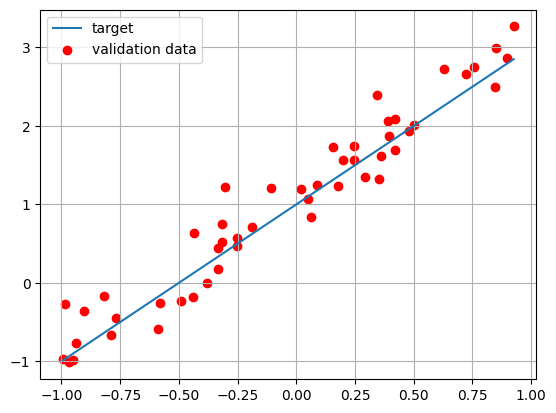

In [4]:
# plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

If you remember how a single node of a neural network works, you can easily spot that **just a single neuron can make the job**. So let's start using a simple Sequential model with just one layer on one neuron only!

In [5]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,))) #un neurone con un parametro, peso w e bias b dato x---> xw+b

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [6]:
# get a summary of our composed model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [7]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 14ms/step - loss: 0.9493 - mse: 0.9493 - val_loss: 0.8607 - val_mse: 0.8607
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 0.5861 - mse: 0.5861 - val_loss: 0.5655 - val_mse: 0.5655
Epoch 3/30
16/16 [==============================] - 0s 3ms/step - loss: 0.3855 - mse: 0.3855 - val_loss: 0.3917 - val_mse: 0.3917
Epoch 4/30
16/16 [==============================] - 0s 3ms/step - loss: 0.2721 - mse: 0.2721 - val_loss: 0.2919 - val_mse: 0.2919
Epoch 5/30
16/16 [==============================] - 0s 3ms/step - loss: 0.2085 - mse: 0.2085 - val_loss: 0.2302 - val_mse: 0.2302
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.1705 - mse: 0.1705 - val_loss: 0.1907 - val_mse: 0.1907
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 0.1467 - mse: 0.1467 - val_loss: 0.1641 - val_mse: 0.1641
Epoch 8/30
16/16 [==============================] - 0s 3ms/step - loss: 0.1311 - mse: 0.1

By looking at weights and biases we can see if the linear fit was successfull: $w_1$ represents the angular coefficient, $b$ the intercept.

In [8]:
# return weights and biases
model.get_weights()

[array([[2.0043814]], dtype=float32), array([0.96726966], dtype=float32)]

In [9]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 3ms/step - loss: 0.1001 - mse: 0.1001

Test loss: 0.10009577870368958
Test accuracy: 0.10009577870368958


In [10]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #

2/2 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011

Test loss: 0.0010924130911007524
Test accuracy: 0.0010924130911007524


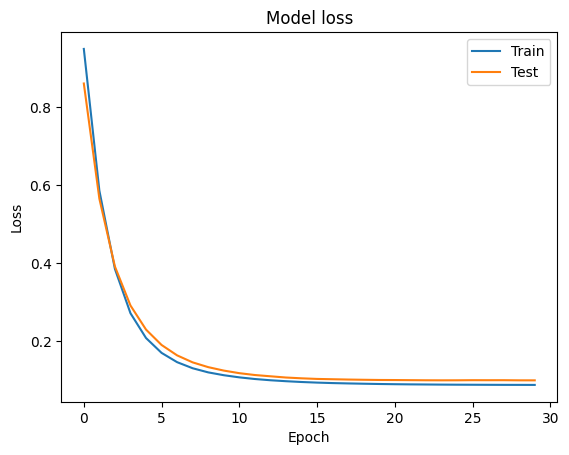

In [11]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

4/4 [==============================] - 0s 1ms/step


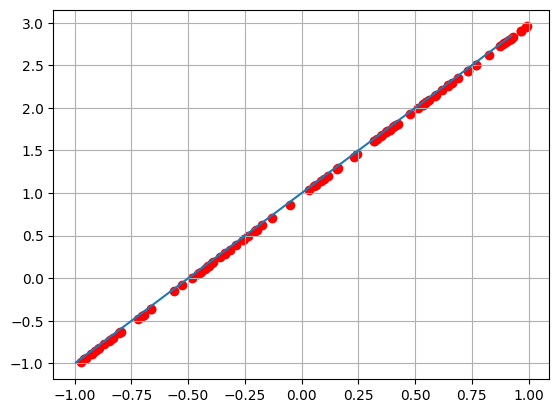

In [12]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Exercise 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

## Cosa succede aumentando il rumore sui dati $\sigma$: 0.3 ---> 0.9

### In questa parte del codice la rete viene inizializzata con un unico neurone denso.

In [13]:

# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

import numpy as np


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.9 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)


#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])


### Qui la rete viene allenata su 30 epoche con $N_{train}=500$ e $N_{test}=50$

In [14]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 8ms/step - loss: 4.1448 - mse: 4.1448 - val_loss: 3.8022 - val_mse: 3.8022
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 3.3251 - mse: 3.3251 - val_loss: 3.0798 - val_mse: 3.0798
Epoch 3/30
16/16 [==============================] - 0s 3ms/step - loss: 2.7401 - mse: 2.7401 - val_loss: 2.5644 - val_mse: 2.5644
Epoch 4/30
16/16 [==============================] - 0s 3ms/step - loss: 2.3176 - mse: 2.3176 - val_loss: 2.1845 - val_mse: 2.1845
Epoch 5/30
16/16 [==============================] - 0s 3ms/step - loss: 1.9957 - mse: 1.9957 - val_loss: 1.8971 - val_mse: 1.8971
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 1.7501 - mse: 1.7501 - val_loss: 1.6773 - val_mse: 1.6773
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 1.5560 - mse: 1.5560 - val_loss: 1.5091 - val_mse: 1.5091
Epoch 8/30
16/16 [==============================] - 0s 3ms/step - loss: 1.4043 - mse: 1.40

2/2 [==============================] - 0s 3ms/step - loss: 0.0096 - mse: 0.0096

Test loss: 0.009580306708812714
Test accuracy: 0.009580306708812714
sigma: 0.9
N_train: 500
[array([[1.9863893]], dtype=float32), array([0.9017082], dtype=float32)]


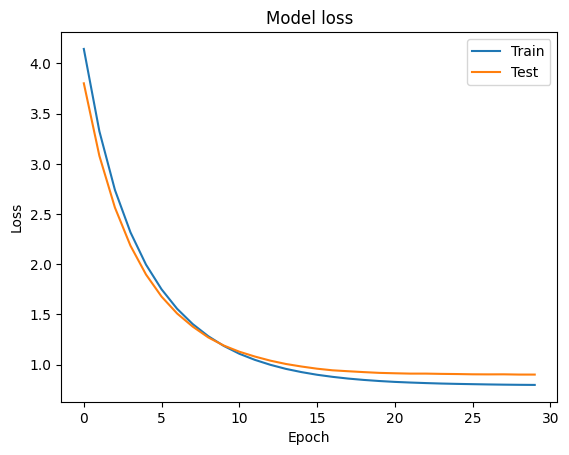

4/4 [==============================] - 0s 1ms/step


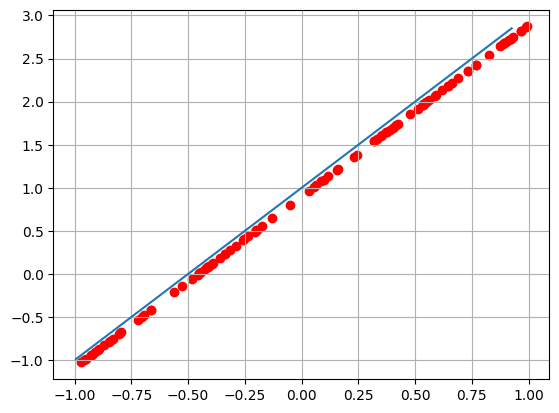

In [15]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)

print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()


Aumentando la  $\sigma$ la funzione loss peggiora, come ci si poteva aspettare.

## Aumentando il numero di epoche: 30 ---> 150

In [17]:



model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])


history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=150,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))



Epoch 1/150
16/16 [==============================] - 0s 8ms/step - loss: 5.6234 - mse: 5.6234 - val_loss: 4.9489 - val_mse: 4.9489
Epoch 2/150
16/16 [==============================] - 0s 3ms/step - loss: 4.5203 - mse: 4.5203 - val_loss: 4.0216 - val_mse: 4.0216
Epoch 3/150
16/16 [==============================] - 0s 3ms/step - loss: 3.7110 - mse: 3.7110 - val_loss: 3.3231 - val_mse: 3.3231
Epoch 4/150
16/16 [==============================] - 0s 3ms/step - loss: 3.0947 - mse: 3.0947 - val_loss: 2.7963 - val_mse: 2.7963
Epoch 5/150
16/16 [==============================] - 0s 3ms/step - loss: 2.6226 - mse: 2.6226 - val_loss: 2.3839 - val_mse: 2.3839
Epoch 6/150
16/16 [==============================] - 0s 3ms/step - loss: 2.2491 - mse: 2.2491 - val_loss: 2.0635 - val_mse: 2.0635
Epoch 7/150
16/16 [==============================] - 0s 3ms/step - loss: 1.9551 - mse: 1.9551 - val_loss: 1.8137 - val_mse: 1.8137
Epoch 8/150
16/16 [==============================] - 0s 3ms/step - loss: 1.7224 - m

2/2 [==============================] - 0s 3ms/step - loss: 0.0152 - mse: 0.0152

Test loss: 0.015172339975833893
Test accuracy: 0.015172339975833893
sigma: 0.9
N_train: 500
[array([[2.0995896]], dtype=float32), array([0.895506], dtype=float32)]


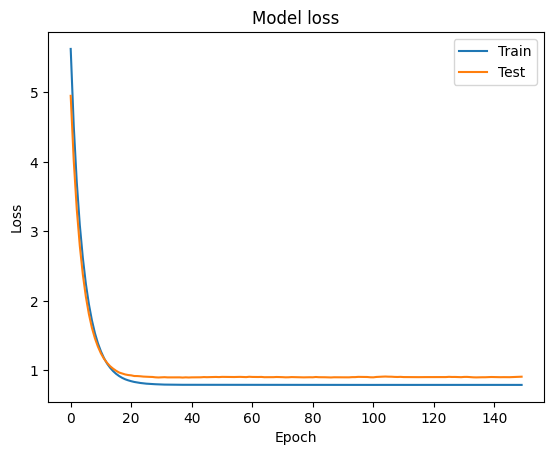

4/4 [==============================] - 0s 1ms/step


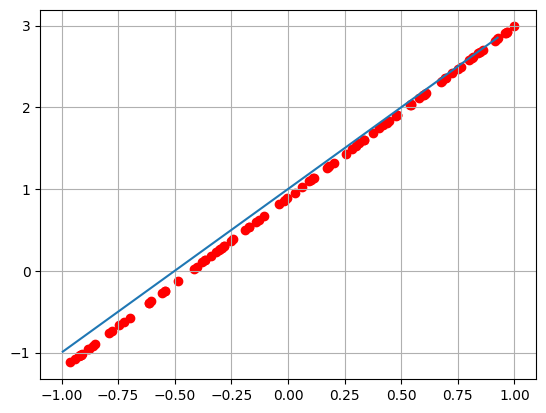

In [19]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)


print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Aumentando il numero di epoche la funzione loss migliora ma non notevolmente, inoltre la funzione di loss di train migliora maggiormente rispetto a quella di test.

## Aumentando invece il numero di dati con cui la rete viene allenata $N_{train}=1000$ 

In [20]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

import numpy as np


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.9 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)


#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,))) #un neurone con un parametro, peso w e bias b dato x---> xw+b

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])


history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))


Epoch 1/30
32/32 [==============================] - 0s 4ms/step - loss: 3.8959 - mse: 3.8959 - val_loss: 3.3473 - val_mse: 3.3473
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 2.5836 - mse: 2.5836 - val_loss: 2.4194 - val_mse: 2.4194
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 1.8799 - mse: 1.8799 - val_loss: 1.8606 - val_mse: 1.8606
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 1.4684 - mse: 1.4684 - val_loss: 1.4994 - val_mse: 1.4994
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 1.2184 - mse: 1.2184 - val_loss: 1.2603 - val_mse: 1.2603
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 1.0602 - mse: 1.0602 - val_loss: 1.0883 - val_mse: 1.0883
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.9555 - mse: 0.9555 - val_loss: 0.9714 - val_mse: 0.9714
Epoch 8/30
32/32 [==============================] - 0s 2ms/step - loss: 0.8872 - mse: 0.88

2/2 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012

Test loss: 0.0012101250467821956
Test accuracy: 0.0012101250467821956
sigma: 0.9
N_train: 1000
[array([[1.968032]], dtype=float32), array([1.0280075], dtype=float32)]


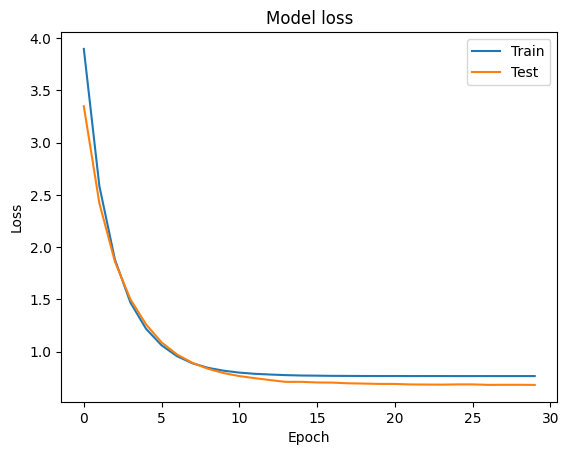

4/4 [==============================] - 0s 1ms/step


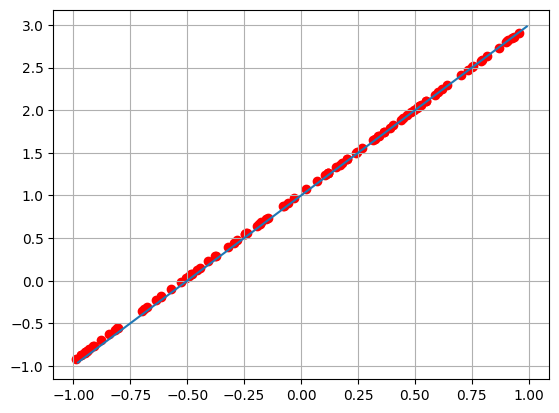

In [21]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)


print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Aumentando solo $N_{train}$ il fit migliora notevolmente cosi come la funzione test loss.
Si nota inoltre come in questo caso la funzione test loss risulti minore di quella di train, questo significa che la rete e' stata in grado di generalizzare al meglio grazie alla maggior varieta' di dati su cui e' stata allenata.

### Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

## Exercise 11.2 Soluzione Proposta

Sono stati utilizzati 3000 dati di train, distribuiti su 80 epoche,  e 100 dati per il test della rete.

La rete proposta e' costituita da neuroni densi con funzione di attivazione la funzione **relu**

Sono di seguito presentate 3 versioni della rete proposta



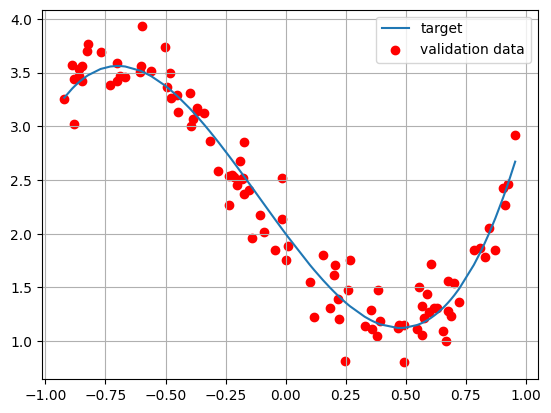

In [22]:

# target parameters of f(x) = a + bx + cxx+ dxxx
a=4
b=-3
c=-2
d=3

import numpy as np

def function(a,b,c,d,x):
    return a+b*x+c+x*x+d*x*x*x

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 3000)
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
y_target = function(a,b,c,d,x_valid) # ideal (target) linear function

sigma = 0.2 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(function(a,b,c,d,x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(function(a,b,c,d,x_valid), sigma)
 # plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()




In [29]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu")) 
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
94/94 [==============================] - 1s 3ms/step - loss: 0.7450 - mse: 0.7450 - val_loss: 0.1520 - val_mse: 0.1520
Epoch 2/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1927 - mse: 0.1927 - val_loss: 0.1448 - val_mse: 0.1448
Epoch 3/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1835 - mse: 0.1835 - val_loss: 0.1420 - val_mse: 0.1420
Epoch 4/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1796 - mse: 0.1796 - val_loss: 0.1400 - val_mse: 0.1400
Epoch 5/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1767 - mse: 0.1767 - val_loss: 0.1360 - val_mse: 0.1360
Epoch 6/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1742 - mse: 0.1742 - val_loss: 0.1353 - val_mse: 0.1353
Epoch 7/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 0.1327 - val_mse: 0.1327
Epoch 8/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1691 - mse: 0.16

## Prima versione

Inizialmente si e' provato ad usare una rete con uno strato composto da 10 neuroni densi e uno strato finale con uun singolo neurone per la combinazione dei risultati, per un totale di 31 parametri.

4/4 [==============================] - 0s 2ms/step - loss: 0.0336 - mse: 0.0336

Test loss: 0.03362967446446419
Test accuracy: 0.03362967446446419
sigma: 0.2
N_train: 3000


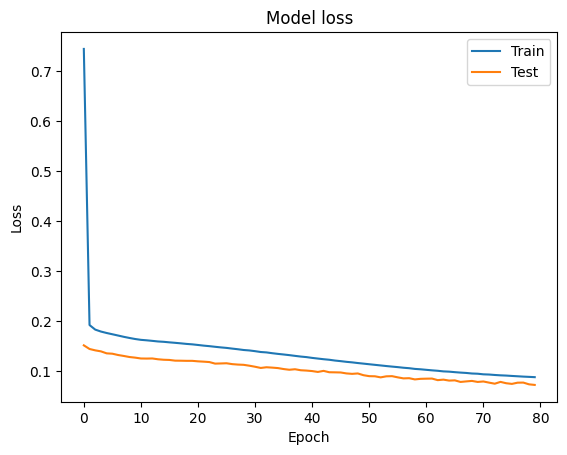

4/4 [==============================] - 0s 1ms/step


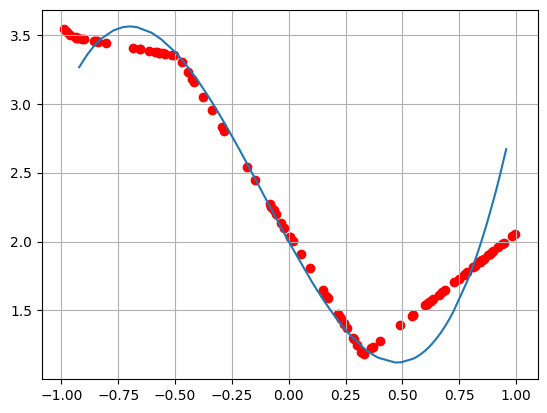

In [31]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Con un solo layer di lavoro la rete e' riuscita' ad intuire l'andamento della funzione ma ha mantenuto la linearita' della funzione di attivazione **relu**.

## Seconda Versione

Succesivamente si e' provato ad aggiungere altri 5 neuroni, ma in un secondo layer di profondita', in modo da aumentare notevolmente le interconnessioni dei neuroni e la complessita' della rete: per un totale di 81 parametri.

In [42]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu"))
model.add(Dense(5, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 10)                20        
                                                                 
 dense_20 (Dense)            (None, 5)                 55        
                                                                 
 dense_21 (Dense)            (None, 1)                 6         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
94/94 [==============================] - 1s 2ms/step - loss: 0.3787 - mse: 0.3787 - val_loss: 0.1321 - val_mse: 0.1321
Epoch 2/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1739 - mse: 0.1739 - val_loss: 0.1296 - val_mse: 0.1296
Epoch 3/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1660 - mse: 0.1660 - val_loss: 0.1236 - val_mse: 0.1236
Epoch 4/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1590 - mse: 0.1590 - val_loss: 0.1191 - val_mse: 0.1191
Epoch 5/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1522 - mse: 0.1522 - val_loss: 0.1156 - val_mse: 0.1156
Epoch 6/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 0.1082 - val_mse: 0.1082
Epoch 7/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1397 - mse: 0.1397 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 8/80
94/94 [==============================] - 0s 1ms/step - loss: 0.1348 - mse: 0.13

4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028

Test loss: 0.0027584368363022804
Test accuracy: 0.0027584368363022804
sigma: 0.2
N_train: 3000


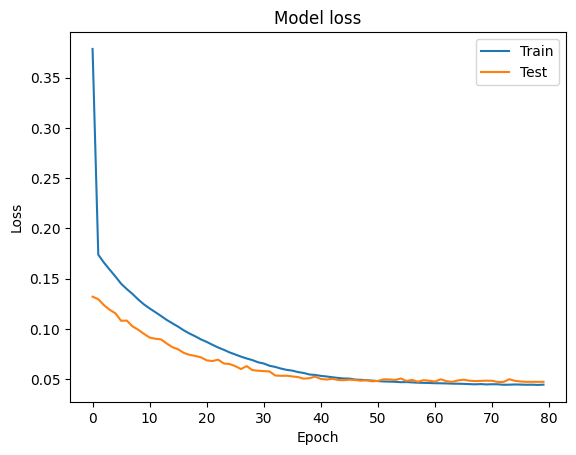

4/4 [==============================] - 0s 1ms/step


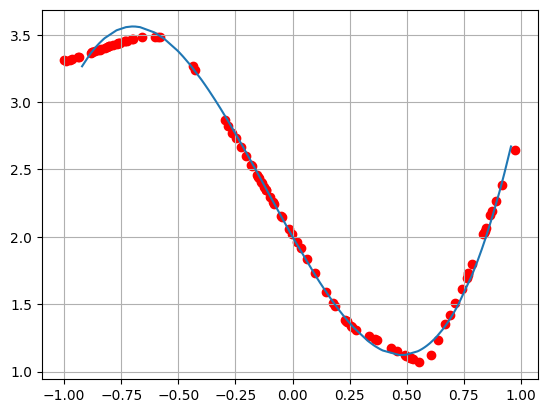

In [44]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Con un secondo layer di profondita' la rete e' stat in grado di intuire l'andamento curvilineo della funzione, mantenendo pero' dei problemi nelle regioni di massimo e di minimo della funzione.

## Versione Finale 

Nella versione finale, il secondo layer e' stato portato a quota 10 neuroni, ed e' stato aggiunto un terzo layer di profondita' composto da 5 neuroni: per un totale di 191 parametri. 

In [57]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu"))
model.add(Dense(10, input_shape=(1,),activation="relu"))
model.add(Dense(5, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                20        
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dense_32 (Dense)            (None, 5)                 55        
                                                                 
 dense_33 (Dense)            (None, 1)                 6         
                                                                 
Total params: 191 (764.00 Byte)
Trainable params: 191 (764.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
94/94 [==============================] - 1s 3ms/step - loss: 0.3957 - mse: 0.3957 - val_loss: 0.1061 - val_mse: 0.1061
Epoch 2/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1270 - mse: 0.1270 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 3/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1177 - mse: 0.1177 - val_loss: 0.0893 - val_mse: 0.0893
Epoch 4/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1109 - mse: 0.1109 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 5/80
94/94 [==============================] - 0s 2ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.0814 - val_mse: 0.0814
Epoch 6/80
94/94 [==============================] - 0s 2ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 7/80
94/94 [==============================] - 0s 2ms/step - loss: 0.0927 - mse: 0.0927 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 8/80
94/94 [==============================] - 0s 1ms/step - loss: 0.0875 - mse: 0.08

4/4 [==============================] - 0s 2ms/step - loss: 6.1068e-04 - mse: 6.1068e-04

Test loss: 0.0006106790388002992
Test accuracy: 0.0006106790388002992
sigma: 0.2
N_train: 3000


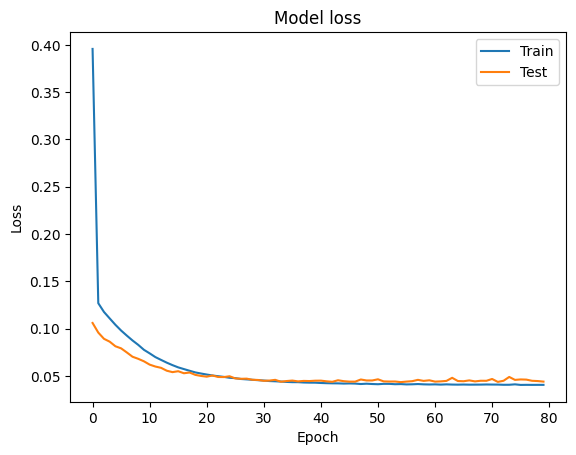

4/4 [==============================] - 0s 1ms/step


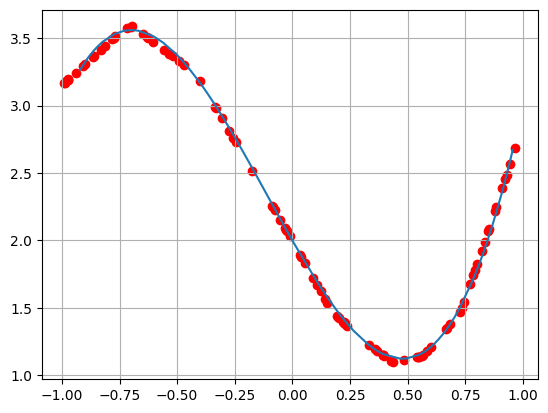

In [61]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Con la versione finale e di complessita' maggiore della rete, questa e' stata in grado di intuire anche l'analicita' delle regioni di massimo e di minimo.

## Fuori dal range di allenamento
 
 La rete e' stata allenata e testata con $x \in [-1,1]$, pertanto, non avendo la rete effetivamente prodotto un fit della funzione ma avendo imparato solo a predire l'output corretto, ci si aspetta che la rete fallisca fuori dal range in cui e' stata allenata.

4/4 [==============================] - 0s 2ms/step


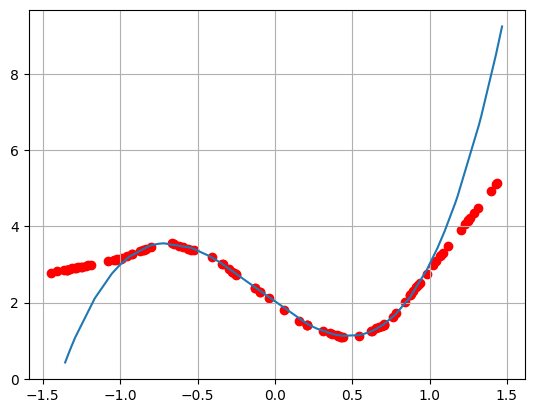

In [62]:
x_predicted = np.random.uniform(-1.5, 1.5, 100)
x_valid=np.random.uniform(-1.5,1.5,50)
x_valid.sort()
y_target = function(a,b,c,d,x_valid)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

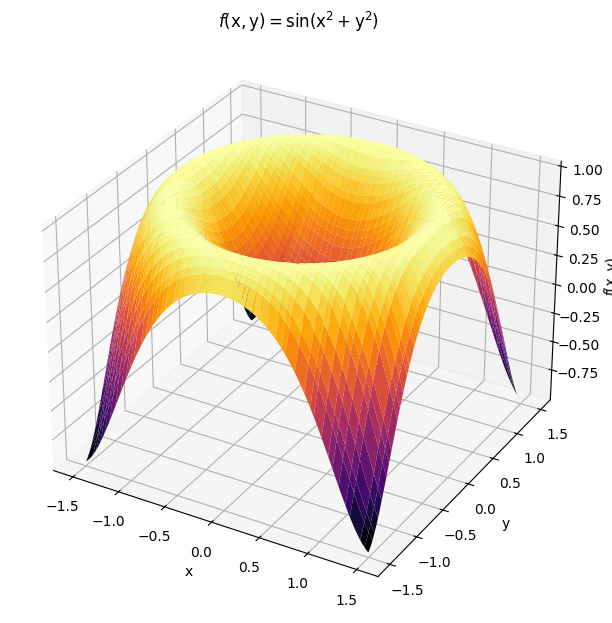

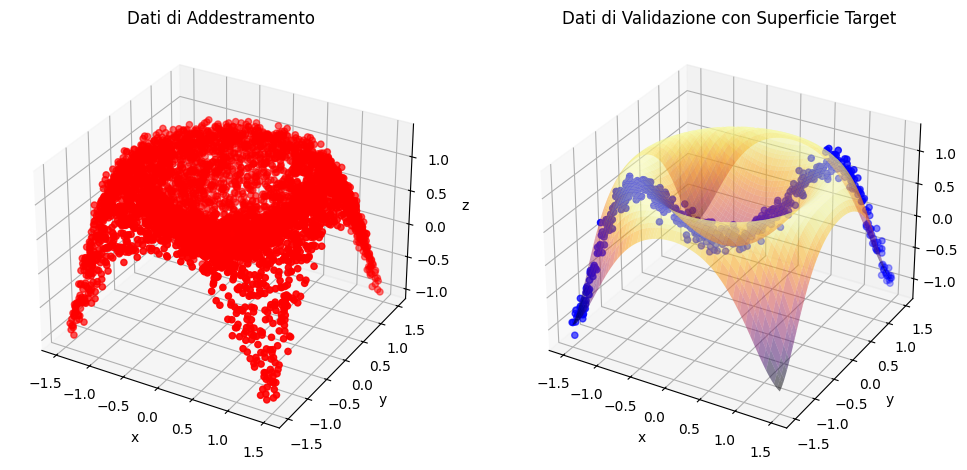

In [63]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-3/2, 3/2, 5000)
y_train = np.random.uniform(-3/2, 3/2, 5000)

x_valid = np.random.uniform(-3/2, 3/2, 500)
x_valid.sort()

y_valid = np.random.uniform(-3/2, 3/2, 500)
y_valid.sort()


z_target=np.sin(x_valid**2+y_valid**2)

sigma = 0.1 # noise standard deviation, for the moment it is absent
z_train = np.random.normal(np.sin(x_train**2+y_train**2), sigma) # actual measures from which we want to guess regression parameters
z_valid = np.random.normal(np.sin(x_valid**2+y_valid**2), sigma)


# plot validation and target dataset
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Create a 3D plot
fig = plt.figure(figsize=(7.5, 7.5))
ax = plt.axes(projection='3d')
x, y = np.meshgrid(x_valid, y_valid)
z = np.sin(x**2 + y**2)

# Plot the function surface
ax.plot_surface(x, y, z, cmap='inferno')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$f(\mathrm{x}, \mathrm{y})$')
ax.set_title('$f(\mathrm{x}, \mathrm{y}) = \sin(\mathrm{x}^2 + \mathrm{y}^2)$')

# Show the plot
plt.show()

# Plot i dati generati insieme alla superficie della funzione target
fig = plt.figure(figsize=(12, 6))

# Plot dei dati di addestramento
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_train, y_train, z_train, c='r', marker='o', label='Dati di addestramento')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Dati di Addestramento')

# Plot dei dati di validazione
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_valid, y_valid, z_valid, c='b', marker='o', label='Dati di validazione')
ax2.plot_surface(x, y, z, cmap='inferno', alpha=0.5, label='Superficie Target')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Dati di Validazione con Superficie Target')

# Show the plot
plt.show()


## Rete proposta

E' stata utilizzata una rete con 32 neuroni densi di tipo **relu** accetanti dati di input di dimensione (x,y) nel primo layer, 16 neuroni **relu** di dimensione unitaria nel secondo, un terzo layer simile al secondo composto pero' da 7 neuroni, e un layer finale da un unico neurone per la produzione dell'output: per un totale di 751 parametri.

La rete e' stata allenata con 5000 dati, su 80 epoche, e testata su 500, entrambi i set di dati con un rumore $\sigma=0.1$.

In [64]:

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(32, input_shape=(2,),activation="relu"))
model.add(Dense(16, input_shape=(1,),activation="relu"))
model.add(Dense(7, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

history = model.fit(x=np.column_stack((x_train, y_train)),
                    y=z_train,
                    batch_size=32,
                    epochs=80,
                    shuffle=True,
                    validation_data=(np.column_stack((x_valid, y_valid)), z_valid))




Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 32)                96        
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 7)                 119       
                                                                 
 dense_37 (Dense)            (None, 1)                 8         
                                                                 
Total params: 751 (2.93 KB)
Trainable params: 751 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/80
157/157 [==============================] - 1s 2ms/step - loss: 0.1955 - mse: 0.1955 - val_loss: 0.3140 - val_mse: 0.3140
Epoch 2/80
157/157 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.0154 - mse: 0.0154

Test loss: 0.015353363007307053
Test accuracy: 0.015353363007307053
sigma: 0.1
N_train: 5000


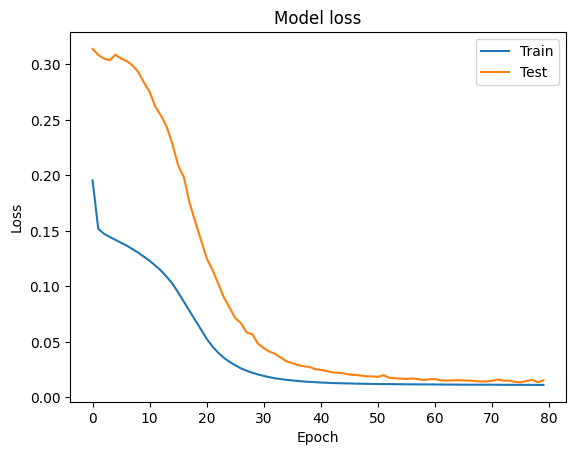

16/16 [==============================] - 0s 1ms/step


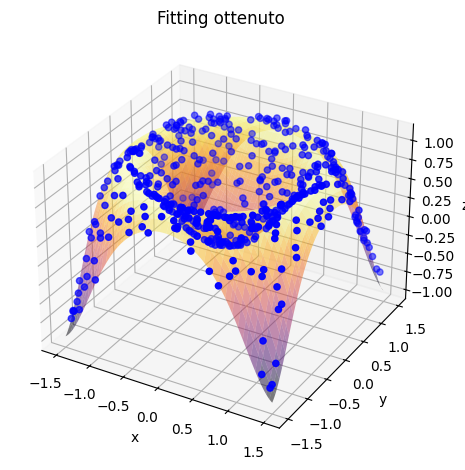

In [66]:
# ...

# Evalutazione del modello sui dati di validazione
score = model.evaluate(np.column_stack((x_valid, y_valid)), z_valid, batch_size=32, verbose=1)

# Stampa delle metriche di performance
print()
print('Test loss:', score[0])  # La funzione costo, ovvero MSE
print('Test accuracy:', score[1])  # Non applicabile in un problema di regressione
print("sigma:", sigma)
print("N_train:", x_train.size)

# Plot della loss durante l'addestramento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Generazione di dati predetti
x_predicted = np.random.uniform(-3/2, 3/2, 500)
y_predicted = np.random.uniform(-3/2, 3/2, 500)
xy_predicted = np.column_stack((x_predicted, y_predicted))
z_predicted = model.predict(xy_predicted)

# Plot dei dati predetti insieme alla superficie target
fig = plt.figure(figsize=(12, 6))

# Plot dei dati predetti
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_predicted, y_predicted, z_predicted, c='b', marker='o', label='Predicted Data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Dati Predetti')

# Plot della superficie target
ax1.plot_surface(x, y, z, cmap='inferno', alpha=0.5, label='Superficie Target')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Fitting ottenuto')

# Mostra il plot
plt.show()
